In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
def dbPath() -> Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    db = dc2.joinpath("data/database_final.db")
    return db

In [3]:
def modelPath(lsoaCode:str) ->Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    modelPath = dc2.joinpath(f"data/models/{lsoaCode}.bin")
    return modelPath

In [4]:
conn = sqlite3.connect(dbPath())
query_lsoa_codes = "SELECT geogcode FROM lsoa_code_to_name"
lsoa_codes = pd.read_sql(query_lsoa_codes, conn)

query_unemployement = "SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"
unemployement = pd.read_sql(query_unemployement, conn)
unemployement.dropna(inplace=True)
unemployement.drop(columns="index", inplace=True)
unemployement = unemployement[(unemployement["date"]<"2020") & (unemployement["date"]>"2012")]


In [5]:
allFeatures = pd.DataFrame(columns=lsoa_codes["geogcode"].to_list(), index=unemployement["date"].unique())
for row in tqdm(unemployement.index):
    allFeatures[unemployement["geogcode"][row]][unemployement["date"][row]] = unemployement["value"][row]

for code in tqdm(lsoa_codes["geogcode"].to_list()):
    for i in range(12):
        allFeatures[f"{code}_shift_{i+1}"] = allFeatures[f"{code}"].shift(i+1)

allFeatures = allFeatures.dropna()
code_out_shift = allFeatures[lsoa_codes["geogcode"].to_list()].copy()
code_with_shift = allFeatures.drop(lsoa_codes["geogcode"].to_list(), axis=True).copy()


  0%|          | 0/17808 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

/tmp/ipykernel_10893/2343870609.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allFeatures[f"{code}_shift_{i+1}"] = allFeatures[f"{code}"].shift(i+1)
/tmp/ipykernel_10893/2343870609.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allFeatures[f"{code}_shift_{i+1}"] = allFeatures[f"{code}"].shift(i+1)
/tmp/ipykernel_10893/2343870609.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

In [6]:
mseDct = {}
modelDct = {}
for col in tqdm(lsoa_codes["geogcode"].to_list()):
    y = code_out_shift[col].copy()
    x = code_with_shift.copy()
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    model = xgb.XGBRegressor()
    model.fit(X_train.values, y_train)
    y_pred = model.predict(X_test.values)
    mseDct[col] = mean_squared_error(y_test, y_pred)
    model.save_model( modelPath(col))

  0%|          | 0/212 [00:00<?, ?it/s]

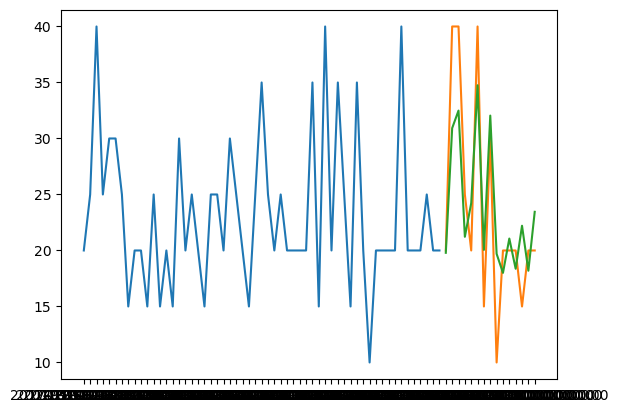

In [7]:
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train)
ax.plot(y_test.index, y_test)
ax.plot(y_test.index, y_pred)

In [8]:
mseDct

{'Column Total': 41491.18846403361,
 'E01000115': 7.414427659531657,
 'E01000116': 5.737109562712658,
 'E01000117': 12.558292382554344,
 'E01000118': 16.107959027152113,
 'E01000119': 10.139049239774703,
 'E01000120': 1.782826484531779,
 'E01000121': 15.494918617565418,
 'E01000122': 10.285206345634,
 'E01000123': 6.863188764965101,
 'E01000124': 12.701134599345096,
 'E01000125': 29.49623872533169,
 'E01000126': 14.211891017919212,
 'E01000127': 7.3164910557097755,
 'E01000128': 15.97966441099361,
 'E01000129': 13.864068871140928,
 'E01000130': 19.759105577093578,
 'E01000131': 17.469031154345977,
 'E01000132': 13.371771447145935,
 'E01000133': 3.08968378419983,
 'E01000134': 7.543797894763459,
 'E01000135': 6.073274891810252,
 'E01000136': 8.362925041887836,
 'E01000137': 14.34402387862962,
 'E01000138': 15.328963726510604,
 'E01000139': 14.660794629188482,
 'E01000140': 16.801903504660853,
 'E01000141': 23.649314978616893,
 'E01000142': 8.53017891992325,
 'E01000143': 16.075653105302